# Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
# from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
from keras.utils import pad_sequences
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM, Embedding

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# Importation du dataset

In [ ]:
!wget https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv

In [2]:
imdb= pd.read_csv("IMDB-Dataset.csv")

In [5]:
imdb.info()
imdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


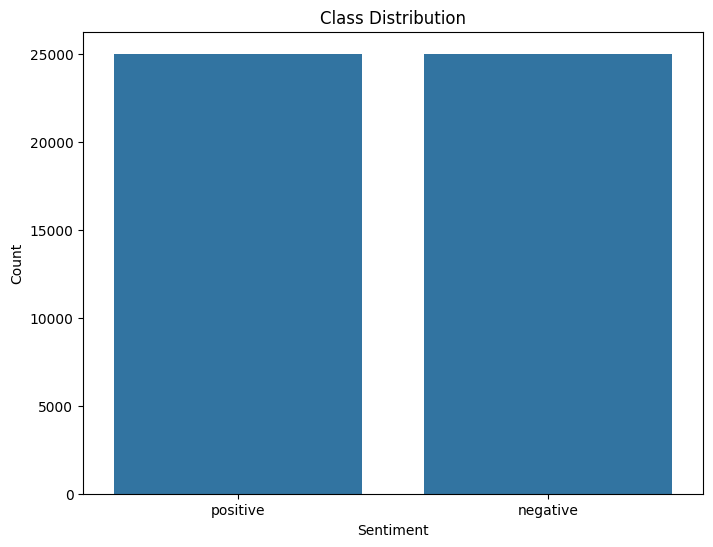

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=imdb)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [7]:
imdb.iloc[3]

review       Basically there's a family where a little boy ...
sentiment                                             negative
Name: 3, dtype: object

# pretraitement

## nettoyer les données textuelles

In [3]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [4]:
X = []
sentences = list(imdb['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [10]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

## convertir les étiquettes en chiffres

In [5]:
y = imdb['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

## Diviser le dataset en training et test sets.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.20, random_state=42)

# La couche de l’embedding

## dictionnaire word-to-index

In [13]:
tokenizer = Tokenizer(num_words=5000) #top 5000 most frequent words
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
X_train[3]

[8,
 1547,
 247,
 2628,
 5,
 443,
 4385,
 1871,
 14,
 30,
 31,
 1062,
 390,
 4,
 968,
 119,
 22,
 118,
 4197,
 29,
 44,
 3,
 1,
 17,
 78,
 118,
 4125,
 122,
 502,
 18,
 2,
 31,
 37,
 555,
 4,
 25,
 2839,
 1,
 2628,
 221,
 77,
 4,
 170,
 1663,
 777,
 57,
 59,
 924,
 7,
 44,
 1974,
 950,
 1164,
 3355,
 57,
 376,
 754,
 264,
 30,
 1318,
 1746,
 1326,
 31,
 376,
 529,
 1135,
 491,
 19,
 4,
 736,
 745,
 701,
 39,
 3,
 1,
 1320,
 3,
 251,
 7,
 8,
 407,
 1,
 103,
 2654,
 1749,
 3813,
 1420,
 3515,
 7,
 1,
 125,
 46,
 130,
 147,
 749,
 9,
 8,
 16,
 266,
 52,
 1975,
 3,
 1,
 3,
 3626,
 13,
 1,
 57,
 6,
 3735,
 7,
 430,
 752,
 2,
 9,
 6,
 5,
 1428,
 4,
 1563,
 2543,
 51,
 1,
 2037,
 15,
 610,
 94,
 1064,
 276,
 3,
 2,
 36,
 1415,
 14,
 57,
 2990,
 2628,
 63,
 29,
 87,
 428,
 332,
 3432]

La taille de chaque liste est différente car les phrases possèdent des tailles différentes.
Le script ci-dessous trouve la taille du vocabulaire, puis effectue un remplissage sur
l'ensemble d'entraînement et de test.

In [15]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [16]:
vocab_size

92547

Les listes ont la même longueur, c'est-à-dire 100. De plus, la variable vocabulary_size contient maintenant une valeur 92547, ce qui signifie que le corpus contient 92547 mots uniques.

##  GloVe : Global Vectors for Word Representation

In [17]:
import urllib.request

urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

KeyboardInterrupt: 

In [ ]:
!unzip "/content/glove.6B.zip" -d "/content/"


créons un dictionnaire qui contiendra des mots en tant que clés et
leur liste d’embeddings correspondante en tant que valeurs.

In [18]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open("glove.6B.100d.txt", encoding="utf8")
for i in range(5):
    line = glove_file.readline()
    print(line)
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:],dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158

Enfin, nous allons créer une matrice d’embeddings où chaque numéro de ligne
correspondra à l'index du mot dans le corpus. La matrice aura 100 colonnes où chaque
colonne contiendra les embeddings GloVe pour les mots de notre corpus.

In [19]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
embedding_matrix[7]

array([ 0.085703  , -0.22201   ,  0.16569   ,  0.13372999,  0.38238999,
        0.35400999,  0.01287   ,  0.22461   , -0.43816999,  0.50164002,
       -0.35874   , -0.34983   ,  0.055156  ,  0.69647998, -0.17958   ,
        0.067926  ,  0.39100999,  0.16039   , -0.26635   , -0.21138   ,
        0.53697997,  0.49379   ,  0.93660003,  0.66902   ,  0.21793   ,
       -0.46641999,  0.22383   , -0.36204001, -0.17656   ,  0.17479999,
       -0.20367   ,  0.13931   ,  0.019832  , -0.10413   , -0.20243999,
        0.55002999, -0.15459999,  0.98654997, -0.26863   , -0.29089999,
       -0.32866001, -0.34187999, -0.16943   , -0.42001   , -0.046727  ,
       -0.16327   ,  0.70823997, -0.74910998, -0.091559  , -0.96178001,
       -0.19746999,  0.10282   ,  0.55220997,  1.38160002, -0.65635997,
       -3.25020003, -0.31556001, -1.20550001,  1.77090001,  0.40259999,
       -0.79826999,  1.15970004, -0.33041999,  0.31382   ,  0.77385998,
        0.22595   ,  0.52471   , -0.034053  ,  0.32047999,  0.07

# modelisation

## A. Classification avec un simple réseau de neurones

In [21]:
# from keras.models import Sequential
# from keras.layers import Embedding, Flatten, Dense

# Création du modèle séquentiel
ann_model = Sequential()

# Ajout de la couche d'embedding
ann_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# Ajout de la couche Flatten
ann_model.add(Flatten())

# Ajout de la couche Dense
ann_model.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
ann_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle
history=ann_model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 4s 5ms/step - loss: 0.5968 - acc: 0.6764 - val_loss: 0.5301 - val_acc: 0.7351
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4916 - acc: 0.7635 - val_loss: 0.5208 - val_acc: 0.7410
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4558 - acc: 0.7870 - val_loss: 0.5165 - val_acc: 0.7495
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4335 - acc: 0.8017 - val_loss: 0.5254 - val_acc: 0.7449
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4169 - acc: 0.8106 - val_loss: 0.5264 - val_acc: 0.7483
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4045 - acc: 0.8151 - val_loss: 0.5457 - val_acc: 0.7441


In [22]:
score = ann_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.5503 - acc: 0.7386
Test Score: 0.550250232219696
Test Accuracy: 0.7386000156402588


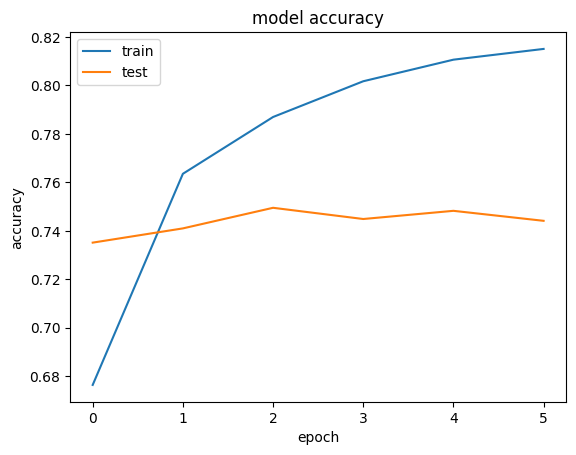

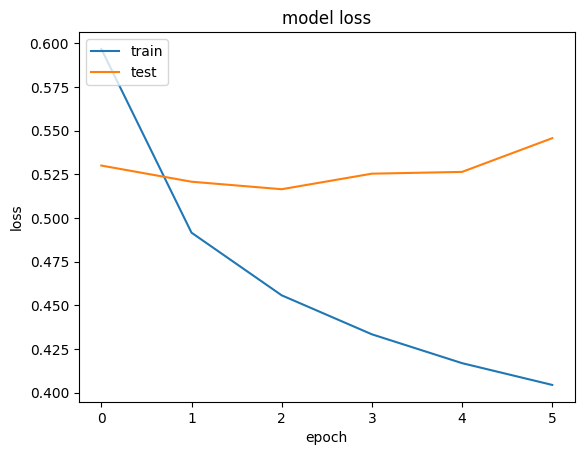

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## B. Classification avec un réseau de neurones convolutionnel

In [24]:
from keras.layers import  Conv1D, MaxPooling1D

cnn_model = Sequential()

cnn_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))

cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

cnn_model.add(MaxPooling1D())

cnn_model.add(Flatten())

cnn_model.add(Dense(units=1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history=cnn_model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 40s 145ms/step - loss: 0.5159 - acc: 0.7286 - val_loss: 0.4180 - val_acc: 0.8061
Epoch 2/6
250/250 [==============================] - 10s 40ms/step - loss: 0.3186 - acc: 0.8625 - val_loss: 0.3353 - val_acc: 0.8556
Epoch 3/6
250/250 [==============================] - 5s 20ms/step - loss: 0.2494 - acc: 0.8997 - val_loss: 0.3324 - val_acc: 0.8605
Epoch 4/6
250/250 [==============================] - 4s 16ms/step - loss: 0.1778 - acc: 0.9360 - val_loss: 0.3498 - val_acc: 0.8535
Epoch 5/6
250/250 [==============================] - 4s 15ms/step - loss: 0.1136 - acc: 0.9656 - val_loss: 0.3859 - val_acc: 0.8512
Epoch 6/6
250/250 [==============================] - 2s 8ms/step - loss: 0.0606 - acc: 0.9881 - val_loss: 0.4374 - val_acc: 0.8454


In [25]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.4180 - acc: 0.8475
Test Score: 0.41801556944847107
Test Accuracy: 0.8475000262260437


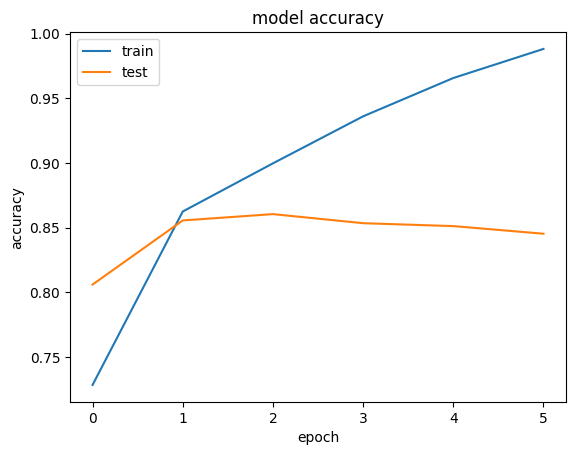

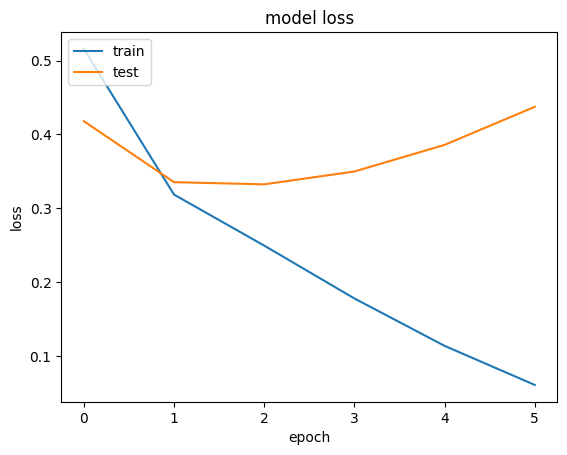

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## C. Classification avec un réseau de neurones récurrent (LSTM)

In [27]:
lstm_model = Sequential()

lstm_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))

lstm_model.add(LSTM(units=128))

lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history=lstm_model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 36s 135ms/step - loss: 0.4990 - acc: 0.7512 - val_loss: 0.3823 - val_acc: 0.8301
Epoch 2/6
250/250 [==============================] - 9s 36ms/step - loss: 0.3391 - acc: 0.8559 - val_loss: 0.3228 - val_acc: 0.8620
Epoch 3/6
250/250 [==============================] - 6s 23ms/step - loss: 0.2861 - acc: 0.8807 - val_loss: 0.3193 - val_acc: 0.8658
Epoch 4/6
250/250 [==============================] - 5s 20ms/step - loss: 0.2566 - acc: 0.8963 - val_loss: 0.3237 - val_acc: 0.8591
Epoch 5/6
250/250 [==============================] - 4s 16ms/step - loss: 0.2312 - acc: 0.9079 - val_loss: 0.3428 - val_acc: 0.8565
Epoch 6/6
250/250 [==============================] - 5s 18ms/step - loss: 0.2059 - acc: 0.9201 - val_loss: 0.3377 - val_acc: 0.8625


In [28]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.3270 - acc: 0.8676
Test Score: 0.3270280957221985
Test Accuracy: 0.8676000237464905


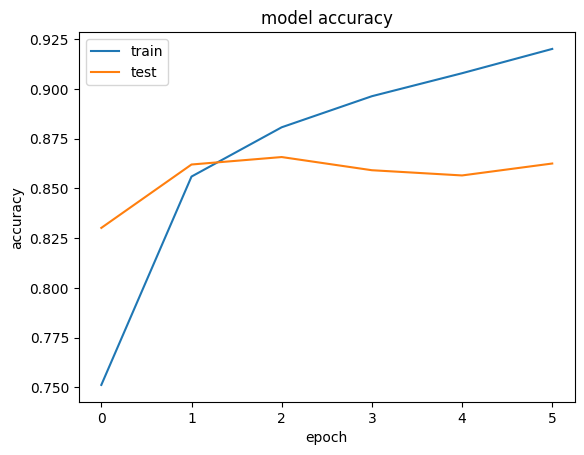

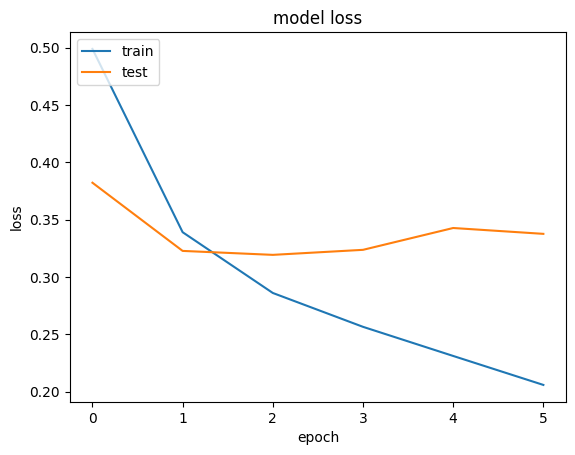

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

l'accuracy du 1er classifieur (un simple réseau de neurones):
l'accuracy du 2eme classifieur (CNN):
l'accuracy du 3eme classifieur (LSTM):


In [30]:
single_input_data = X_test[4]
input_data = np.array([single_input_data])
predicted_prob = lstm_model.predict(input_data)

predicted_class = int(np.round(predicted_prob))

print("Predicted Probability:", predicted_prob)
print("Predicted Class:", predicted_class)
print("correct Class:", y_test[4])

1/1 [==============================] - 0s 408ms/step
Predicted Probability: [[0.00236387]]
Predicted Class: 0
correct Class: 0


<ipython-input-30-0ded7bee6307>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(np.round(predicted_prob))


# comparaison embedding / classifieur

## utils

In [31]:
def plot_results(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

def evaluate_model(model):
  score = model.evaluate(X_test, y_test, verbose=0)
  print("Test Score:", score[0])
  print("Test Accuracy:", score[1])

## models

In [12]:
from keras.layers import  GRU

from keras.callbacks import EarlyStopping

def train_lstm(out_dim):
    lstm_model = Sequential()

    lstm_model.add(Embedding(vocab_size, out_dim, weights=[embedding_matrix], input_length=maxlen))

    lstm_model.add(LSTM(units=128))

    lstm_model.add(Dense(units=1, activation='sigmoid'))

    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = lstm_model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping])

    return lstm_model, history

def train_cnn_rnn(out_dim):
    model = Sequential()

    model.add(Embedding(vocab_size, out_dim, weights=[embedding_matrix], input_length=maxlen))

    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    model.add(MaxPooling1D())
    model.add(LSTM(units=128))


    model.add(Flatten())

    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping])

    return model, history

def train_gru(out_dim):
    model = Sequential()

    model.add(Embedding(vocab_size, out_dim, weights=[embedding_matrix], input_length=maxlen))

    model.add(GRU(units=128))

    model.add(Flatten())

    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping])

    return model , history


In [33]:
def experience(out_dim, train ):
    model, history= train(out_dim)
    plot_results(history)
    evaluate_model(model)


In [ ]:
experience(100, train_cnn_rnn)

In [ ]:
experience(100, train_gru)

pour l'emmbedding avec Glove on a :
- lstm: .8655
- cnn+ rnn: .8672
- gru: .8768






## word2vec

In [ ]:
!wget https://media.githubusercontent.com/media/eyaler/word2vec-slim/master/GoogleNews-vectors-negative300-SLIM.bin.gz

In [ ]:
!gunzip /content/GoogleNews-vectors-negative300-SLIM.bin.gz


In [ ]:
from gensim.models import KeyedVectors

# Load word2vec model
word2vec_model = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300-SLIM.bin', binary=True)

# Create an empty dictionary to store word vectors
embeddings_dictionary = {}

# Iterate through the word2vec model vocabulary and store word vectors in the dictionary
for word in word2vec_model.key_to_index:
    embeddings_dictionary[word] = word2vec_model[word]

# Initialize the embedding matrix with zeros
embedding_matrix = zeros((vocab_size, word2vec_model.vector_size))

# Iterate through tokenizer word index and update the embedding matrix with word vectors
for word, index in tokenizer.word_index.items():
    if word in embeddings_dictionary:
        embedding_matrix[index] = embeddings_dictionary[word]


In [ ]:
from scipy.spatial.distance import cosine

# Calculate cosine similarity between "dog" and "cat"
dog_embedding = embedding_matrix[tokenizer.word_index["dog"]]
cat_embedding = embedding_matrix[tokenizer.word_index["cat"]]
similarity = 1 - cosine(dog_embedding, cat_embedding)
print(f"Similarity between 'dog' and 'cat': {similarity:.2f}")

In [ ]:
embedding_matrix.shape[1]

In [ ]:
experience(embedding_matrix.shape[1], train_lstm)

In [ ]:
experience(embedding_matrix.shape[1], train_cnn_rnn)

In [ ]:
experience(embedding_matrix.shape[1], train_gru)

| Modèle      | Score    |
|-------------|----------|
| LSTM        | 0.863   |
| CNN + RNN   | 0.872   |
| GRU         | 0.861   |


##  [fasttext](https://www.kaggle.com/code/vsmolyakov/keras-cnn-with-fasttext-embeddings)

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec

In [ ]:
import codecs
embeddings_dictionary = {}
f = codecs.open('wiki.en.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coef = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coef
f.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        if embedding_vector.shape==(0,):
          continue
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix[200].shape

In [ ]:
# Calculate cosine similarity between "dog" and "cat"
dog_embedding = embedding_matrix[tokenizer.word_index["dog"]]
cat_embedding = embedding_matrix[tokenizer.word_index["cat"]]
similarity = 1 - cosine(dog_embedding, cat_embedding)
print(f"Similarity between 'dog' and 'cat': {similarity:.2f}")

In [ ]:
# import fasttext.util

# fasttext.util.download_model('en', if_exists='ignore')
# ft = fasttext.load_model('cc.en.300.bin')



In [ ]:
experience(embedding_matrix.shape[1], train_lstm)

In [ ]:
experience(embedding_matrix.shape[1], train_cnn_rnn)

In [ ]:
experience(embedding_matrix.shape[1], train_gru)

| Modèle      | Score    |
|-------------|----------|
| LSTM        | 0.861   |
| CNN + RNN   | 0.873   |
| GRU         | 0.874   |



## TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(X)
tfidf_matrix = tfidf_matrix.toarray()

In [7]:
tfidf_matrix[17].shape

(1000,)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)


In [20]:
from keras.layers import Reshape

def train_lstm_with_tfidf(output_dim=128):
    lstm_model = Sequential()
    lstm_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    lstm_model.add(Reshape((64, 1))) 

    lstm_model.add(LSTM(128))
    lstm_model.add(Dense(1, activation='sigmoid'))

    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = lstm_model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping], validation_data=(X_test, y_test))

    return lstm_model, history

def train_cnn_rnn_with_tfidf(output_dim=128):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Reshape((64, 1))) 
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D())
    model.add(LSTM(units=128))
    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping], validation_data=(X_test, y_test))

    return model, history

def train_gru_with_tfidf(output_dim=128):

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Reshape((64, 1))) 
    model.add(GRU(units=128))
    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping],  validation_data=(X_test, y_test))

    return model , history

The embedding layer is typically used when dealing with text data where words are represented as discrete categorical variables. It transforms these variables into continuous vectors that capture semantic meaning. However, in our case, we’re using TF-IDF vectors as input, which are already continuous and capture some level of semantic meaning. Therefore, the embedding layer might not be necessary and could even distort the TF-IDF features.

In [16]:
model , history= train_lstm_with_tfidf(128)

Epoch 1/6
313/313 [==============================] - 108s 317ms/step - loss: 0.4588 - acc: 0.7935 - val_loss: 0.3167 - val_acc: 0.8658
Epoch 2/6
313/313 [==============================] - 101s 324ms/step - loss: 0.3122 - acc: 0.8677 - val_loss: 0.3056 - val_acc: 0.8693
Epoch 3/6
313/313 [==============================] - 127s 406ms/step - loss: 0.3110 - acc: 0.8708 - val_loss: 0.3075 - val_acc: 0.8693
Epoch 4/6
313/313 [==============================] - 104s 334ms/step - loss: 0.2914 - acc: 0.8789 - val_loss: 0.3128 - val_acc: 0.8670
Epoch 5/6
313/313 [==============================] - 84s 269ms/step - loss: 0.2754 - acc: 0.8865 - val_loss: 0.3063 - val_acc: 0.8713


In [17]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


313/313 [==============================] - 20s 64ms/step - loss: 0.3056 - acc: 0.8693
Test Score: 0.3056498169898987
Test Accuracy: 0.8693000078201294


In [22]:
from keras.layers import  Conv1D, MaxPooling1D


In [24]:
model , history= train_cnn_rnn_with_tfidf(128)
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
313/313 [==============================] - 63s 165ms/step - loss: 0.3924 - acc: 0.8108 - val_loss: 0.3056 - val_acc: 0.8683
Epoch 2/6
313/313 [==============================] - 51s 162ms/step - loss: 0.2909 - acc: 0.8807 - val_loss: 0.3035 - val_acc: 0.8692
Epoch 3/6
313/313 [==============================] - 69s 219ms/step - loss: 0.2595 - acc: 0.8952 - val_loss: 0.3248 - val_acc: 0.8624
Epoch 4/6
313/313 [==============================] - 52s 165ms/step - loss: 0.2107 - acc: 0.9184 - val_loss: 0.3557 - val_acc: 0.8610
Epoch 5/6
313/313 [==============================] - 7s 22ms/step - loss: 0.3035 - acc: 0.8692
Test Score: 0.3035370409488678
Test Accuracy: 0.8691999912261963


In [25]:
model , history= train_gru_with_tfidf(128)
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
313/313 [==============================] - 68s 192ms/step - loss: 0.4085 - acc: 0.8030 - val_loss: 0.3023 - val_acc: 0.8690
Epoch 2/6
313/313 [==============================] - 51s 164ms/step - loss: 0.3035 - acc: 0.8700 - val_loss: 0.2998 - val_acc: 0.8708
Epoch 3/6
313/313 [==============================] - 52s 167ms/step - loss: 0.2913 - acc: 0.8756 - val_loss: 0.3026 - val_acc: 0.8703
Epoch 4/6
313/313 [==============================] - 54s 172ms/step - loss: 0.2725 - acc: 0.8862 - val_loss: 0.3027 - val_acc: 0.8688
Epoch 5/6
313/313 [==============================] - 10s 32ms/step - loss: 0.2998 - acc: 0.8708
Test Score: 0.2998371720314026
Test Accuracy: 0.8708000183105469


| Modèle      | Score    |
|-------------|----------|
| LSTM        | 0.8693000078201294   |
| CNN + RNN   | 0.8691999912261963   |
| GRU         | 0.8708000183105469  |

